In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import (
    FitzHughNagumoProcess,
    FitzHughNagumoAuxProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLPSmall
from neuralbridge.models import neurb, pCN
from neuralbridge.utils.plotting import plot_sample_path, plot_mcmc_sample_path

### Stochastic hypo-elliptic FitzHugh-Nagumo model
Consider a ODE/SDE-mixed model:
$$
\mathrm{d}X_t = \left\{
\begin{bmatrix}
    1/\varepsilon & -1/\varepsilon \\
    \gamma & -1
\end{bmatrix}X_t + 
\begin{bmatrix}
    -X^3_{t,1}/\varepsilon + s / \varepsilon \\
    b
\end{bmatrix}
\right\} \mathrm{d}t +
\begin{bmatrix}
    0 & 0 \\
    0 & \sigma
\end{bmatrix} \mathrm{d}W_t,
$$
where only the first component of $X_t$ is observed, that is $L = [1,0]$, construct the auxiliary process as:
$$
\mathrm{d}\tilde{X}_t = \left\{
\begin{bmatrix}
    1/\varepsilon-3\nu^3/\varepsilon & -1/\varepsilon \\
    \gamma & -1
\end{bmatrix}X_t + 
\begin{bmatrix}
    2\nu^3 /\varepsilon + s / \varepsilon \\
    b
\end{bmatrix}
\right\} \mathrm{d}t +
\begin{bmatrix}
    0 & 0 \\
    0 & \sigma
\end{bmatrix} \mathrm{d}W_t,
$$

### Conditioning on "normal" event

In [3]:
dim = 2
shape = (1,)
T = 2.0
dt = 1. / 200

# parameter settings, see "Simulation of Elliptic and Hypo-Elliptic Conditional Diffusions" (4.3)
params = {
    "epsilon": 0.1,
    "s": 0.0,
    "gamma": 1.5,
    "beta": 0.8,
    "sigma": 0.3,
    "nu": 0.5
}

seed = 42
u = jnp.array([-0.5, -0.6])
v = jnp.array([-1.0])
print(f"u.shape = {u.shape}, v.shape = {v.shape}")

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


u.shape = (2,), v.shape = (1,)


In [4]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_process = WienerProcess(T, dt, shape, t_scheme=t_scheme)
ori_proc = FitzHughNagumoProcess(params, T, dim)
aux_proc = FitzHughNagumoAuxProcess(params, T, dim)

ori_solver = Euler(ori_proc, wiener_process)
aux_solver = Euler(aux_proc, wiener_process)

rng_key = jax.random.PRNGKey(seed)

In [5]:
batch_size = 16
ori_path = ori_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
aux_path = aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)

In [6]:
guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.array([1., 0.]).reshape(1, 2), 
    Sigma0=jnp.eye(1) * 1e-4, 
    ts=jnp.arange(0, T + dt, dt),
    ode_solver_kernel=ode_solver_kernel
)

guided_solver = Euler(guided_proc, wiener_process)
guided_path = guided_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)

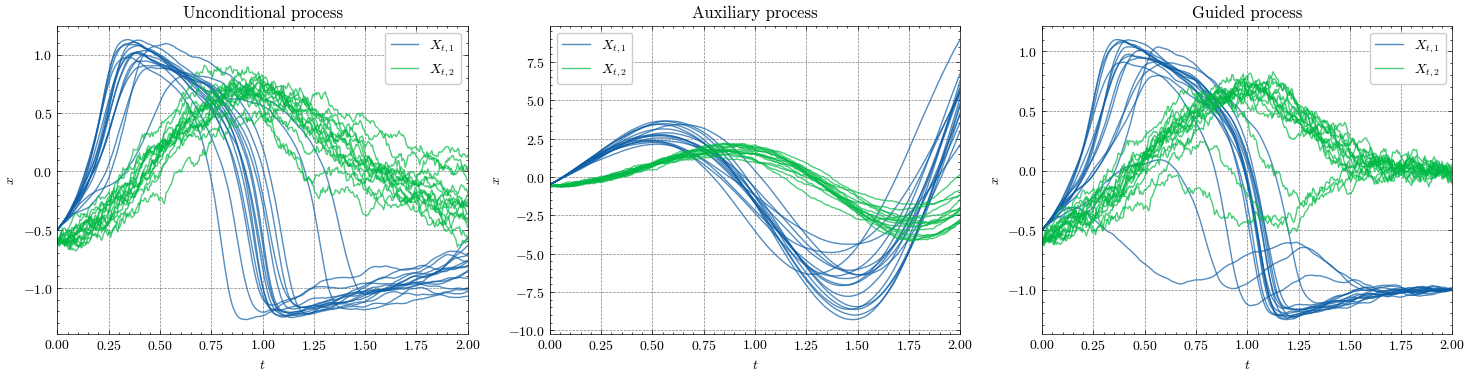

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
plot_sample_path(ori_path, ax=axes[0], label=["$X_{t,1}$", "$X_{t,2}$"], title="Unconditional process")
plot_sample_path(aux_path, ax=axes[1], label=["$X_{t,1}$", "$X_{t,2}$"], title="Auxiliary process")
plot_sample_path(guided_path, ax=axes[2], label=["$X_{t,1}$", "$X_{t,2}$"], title="Guided process")
plt.show()

In [8]:
pCN_config = {
    "seed": seed,
    "rho": 0.0,
    "batch_size": 16,
    "n_iters": 50000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_process)
pCN_result = pCN_model.run_pCN(log_every=1000)

  0%|          | 0/50000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 13.01%


Text(0.5, 1.0, 'MCMC Log-likelihood')

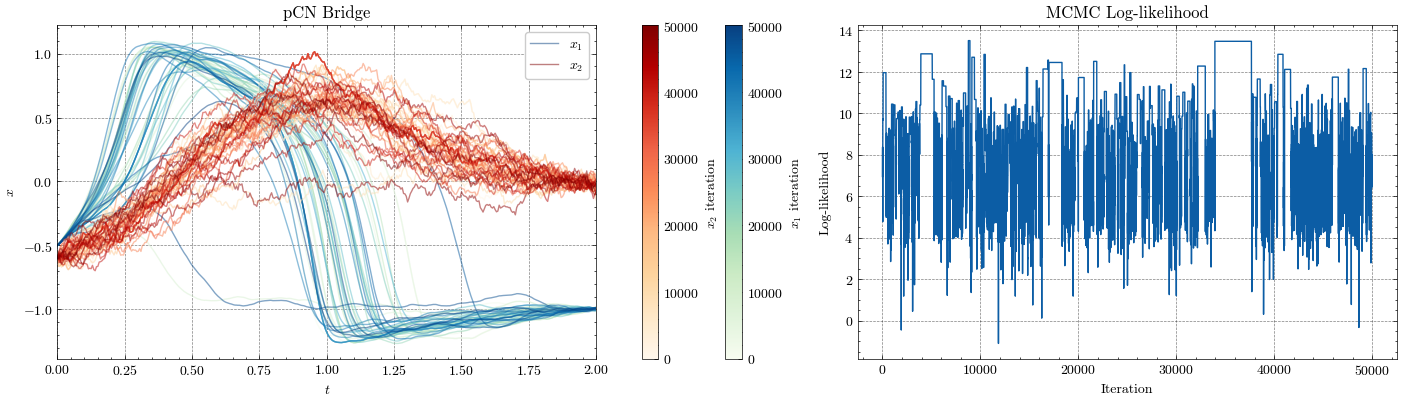

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), layout="constrained")
plot_mcmc_sample_path(pCN_result, sample_index=0, ax=ax[0], cmap=["GnBu", "OrRd"], label=["$x_1$", "$x_2$"], title="pCN Bridge", alpha=0.5, n_iters=50000)

ax[1].plot(pCN_result[-1].log_lls[:, 0])
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Log-likelihood")
ax[1].set_title("MCMC Log-likelihood")

In [17]:
neural_net = MLPSmall(
    out_dim=1,
    hidden_dims=(20, 20, 20, 20),
    activation="tanh",
)

In [18]:
train_config = {
    "save_name": "FHN_model_2T",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 64,
    "n_iters": 200,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [19]:
neural_bridge = neurb.NeuralBridge(
    guided_bridge=guided_proc,
    neural_net=neural_net,
    train_config=train_config
)
neural_bridge.initialize_path_solver(wiener_process)

In [20]:
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="pretrained")

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/FHN_model_2T
INFO:root:Loading pretrained model from the last epoch


In [21]:
neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

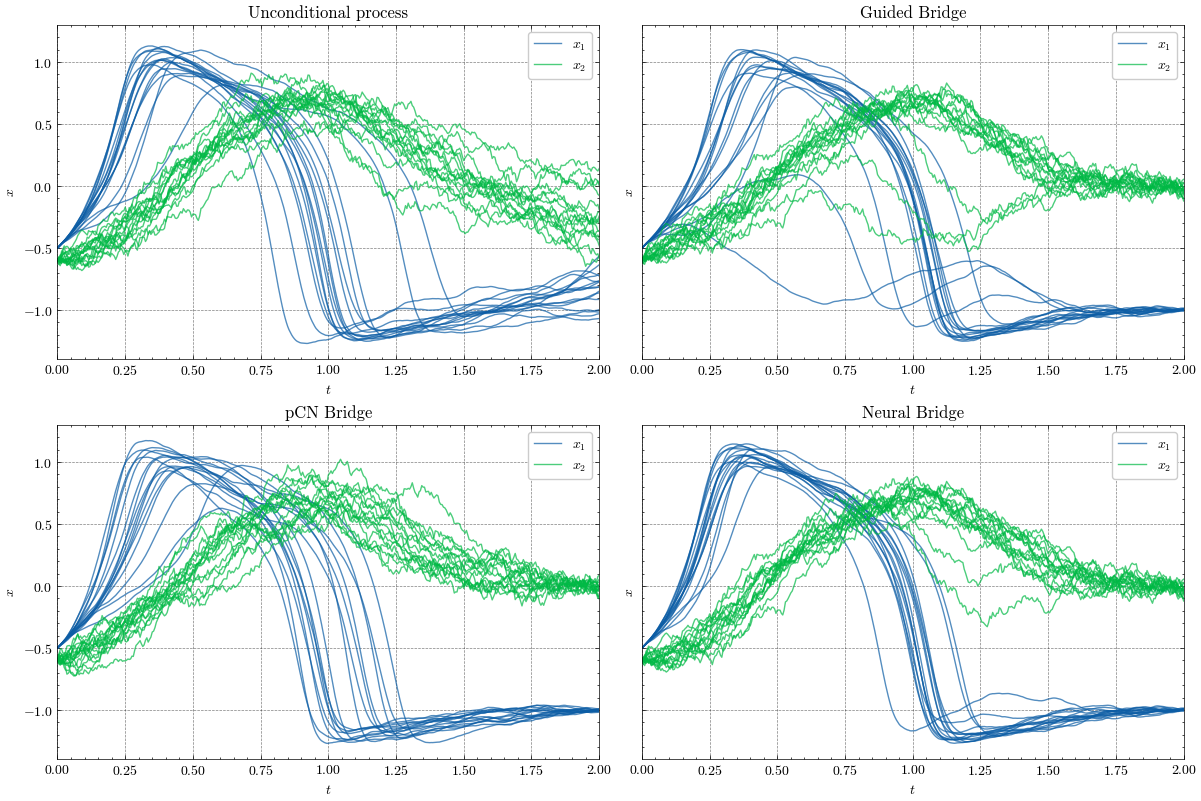

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), layout="constrained", sharey=True)
plot_sample_path(ori_path, ax=ax[0, 0], label=["$x_1$", "$x_2$"], title="Unconditional process")
plot_sample_path(guided_path, ax=ax[0, 1], label=["$x_1$", "$x_2$"], title="Guided Bridge")
plot_sample_path(pCN_result[-1].path, ax=ax[1, 0], label=["$x_1$", "$x_2$"], title="pCN Bridge")
plot_sample_path(neural_bridge_path, ax=ax[1, 1], label=["$x_1$", "$x_2$"], title="Neural Bridge")
plt.show()

### Conditioning on "extreme" event

In [26]:
dim = 2
shape = (1,)
T = 2.0
dt = 1. / 200

# parameter settings, see "Simulation of Elliptic and Hypo-Elliptic Conditional Diffusions" (4.3)
params = {
    "epsilon": 0.1,
    "s": 0.0,
    "gamma": 1.5,
    "beta": 0.8,
    "sigma": 0.3,
    "nu": 0.5
}

seed = 42
u = jnp.array([-0.5, -0.6])
v = jnp.array([1.1])
print(f"u.shape = {u.shape}, v.shape = {v.shape}")

u.shape = (2,), v.shape = (1,)


In [27]:
guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.array([1., 0.]).reshape(1, 2), 
    Sigma0=jnp.eye(1) * 1e-4, 
    ts=jnp.arange(0, T + dt, dt),
    ode_solver_kernel=ode_solver_kernel
)

guided_solver = Euler(guided_proc, wiener_process)
guided_path = guided_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)

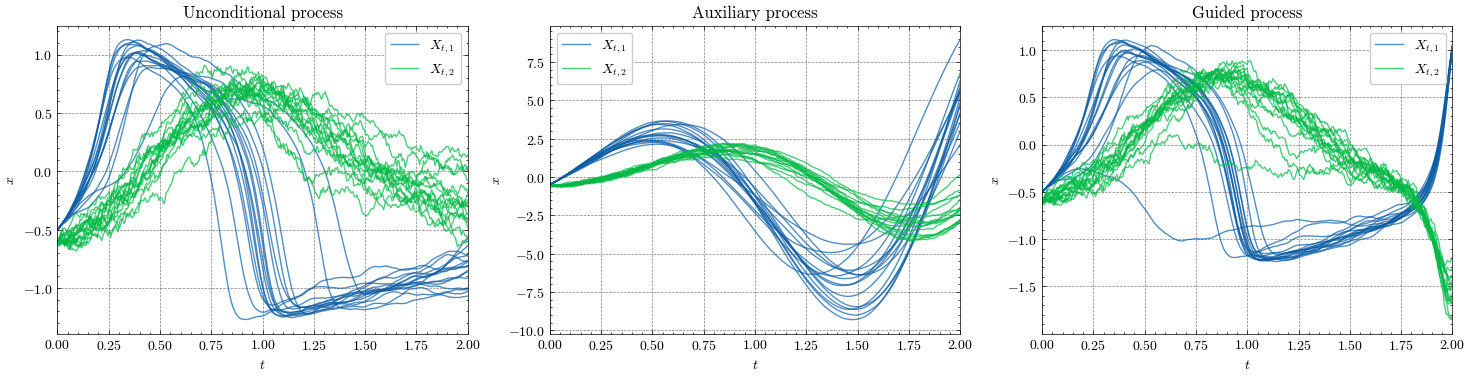

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
plot_sample_path(ori_path, ax=axes[0], label=["$X_{t,1}$", "$X_{t,2}$"], title="Unconditional process")
plot_sample_path(aux_path, ax=axes[1], label=["$X_{t,1}$", "$X_{t,2}$"], title="Auxiliary process")
plot_sample_path(guided_path, ax=axes[2], label=["$X_{t,1}$", "$X_{t,2}$"], title="Guided process")
plt.show()

In [29]:
pCN_config = {
    "seed": seed,
    "rho": 0.9,
    "batch_size": 16,
    "n_iters": 50000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_process)
pCN_result = pCN_model.run_pCN(log_every=1000)

  0%|          | 0/50000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 0.40%


Text(0.5, 1.0, 'MCMC Log-likelihood')

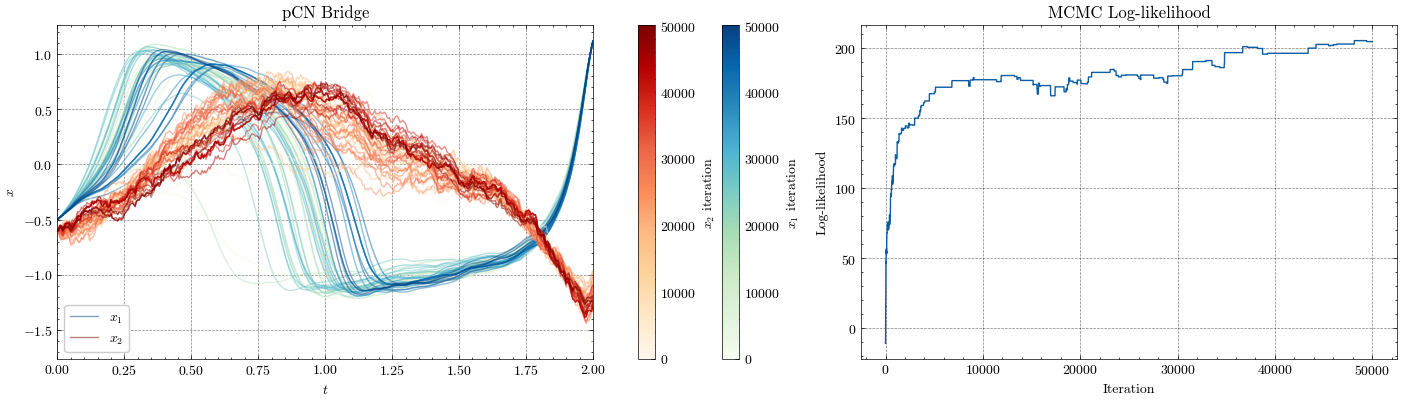

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), layout="constrained")
plot_mcmc_sample_path(pCN_result, sample_index=0, ax=ax[0], cmap=["GnBu", "OrRd"], label=["$x_1$", "$x_2$"], title="pCN Bridge", alpha=0.5, n_iters=50000)

ax[1].plot(pCN_result[-1].log_lls[:, 0])
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Log-likelihood")
ax[1].set_title("MCMC Log-likelihood")

In [31]:
neural_net = MLPSmall(
    out_dim=1,
    hidden_dims=(20, 20, 20, 20),
    activation="tanh",
)

In [32]:
train_config = {
    "save_name": "FHN_model_2T_extreme",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 64,
    "n_iters": 200,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 0
}

In [33]:
neural_bridge = neurb.NeuralBridge(
    guided_bridge=guided_proc,
    neural_net=neural_net,
    train_config=train_config
)
neural_bridge.initialize_path_solver(wiener_process)

In [34]:
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="pretrained")

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/FHN_model_2T_extreme
INFO:root:Loading pretrained model from the last epoch


In [35]:
neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

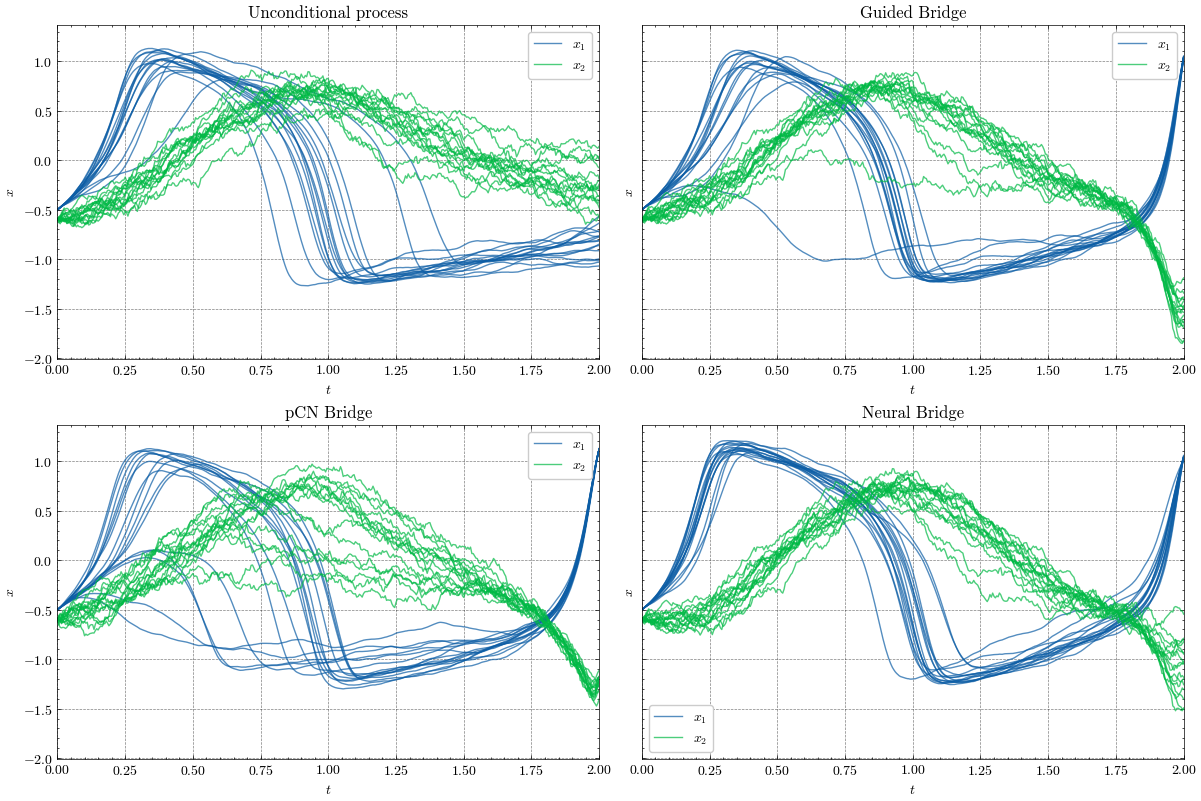

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), layout="constrained", sharey=True)
plot_sample_path(ori_path, ax=ax[0, 0], label=["$x_1$", "$x_2$"], title="Unconditional process")
plot_sample_path(guided_path, ax=ax[0, 1], label=["$x_1$", "$x_2$"], title="Guided Bridge")
plot_sample_path(pCN_result.path, ax=ax[1, 0], label=["$x_1$", "$x_2$"], title="pCN Bridge")
plot_sample_path(neural_bridge_path, ax=ax[1, 1], label=["$x_1$", "$x_2$"], title="Neural Bridge")
plt.show()